In [1]:
# read txt document of entry points
# also iterate over all tif files (adult 3D mask images) in the same path and perform analysis 
# all analysis except column analysis 

In [1]:
from tqdm import tqdm
import os
import re
import tifffile as tif

import utils.analysis as analysis

import numpy as np
from skimage.measure import regionprops, marching_cubes, mesh_surface_area
import pandas as pd
import math
from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from matplotlib import colors
# import seaborn as sns
%matplotlib inline

In [2]:
#  input and save paths
data_path = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/'
save_path = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/output/'

In [3]:
# getting list of image file names in data_path
N_folders = [name for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
N_folders = [f for f in N_folders if '.tif' in f]
N_folders = sorted(N_folders)
N_folders[:5]

['T4-02_A.tif', 'T4-03_D.tif', 'T4-04_B.tif', 'T4-05_D.tif', 'T4-06_D.tif']

In [4]:
# reading erntry_points file and converting it to dictionary of neu:[z,y,x]
EP_file = '/Volumes/Samsung_T5/adult_cntrl/preprocessed/Adults_ctrl_entry_points'
with open(EP_file) as f:
    entry_points = f.readlines()
entry_points = [l for l in entry_points if ': ' in l]
entry_points = [l.rstrip('\n').split(':') for l in entry_points]
entry_points = {l[0]: l[1].split(',') for l in entry_points}
entry_points = {neu:[int(x) for x in val] for neu,val in entry_points.items()}

In [16]:
results_cols = ['neuron','subtype','volume','area',
                'area_scipy', 'peri_scipy', 'circ_scipy', 'dens_scipy',
                'density', 'perimeter', 'compactness', 'eccentricity',
                'circularity2', 'convexity',
                'surface_area','circularity','AP_spread',
                'DV_spread','DGI',
                'centroidZ','centroidY', 'centroidX', 'cen_EP_dis',
                'asymmetry', 'feret_diameter_max', 'orientation', #orientation is from regionprops
                'xP_weight','xP_scale','xP_angle','xP_xy', #all of this part is for the results from PCA_analysis
                'xN_weight','xN_scale','xN_angle','xN_xy',
                'yP_weight','yP_scale','yP_angle','yP_xy',
                'yN_weight','yN_scale','yN_angle','yN_xy',
                'PCA_angle','PCA_xy','PCA_shift_centroid']
results_df = pd.DataFrame(columns=results_cols)

In [17]:
# iterating over files in data_path and performing the analysis
for i, neu_file in tqdm(enumerate(N_folders)):
    # try:
        # for k in [1]:
            # print(neu_file)
            neu_res = {}
            # getting entry point
            try:
                neu_res['subtype'] = neu_file[-5]
            except:
                neu_res['subtype'] = 'N'
            # neu_res['neuron'] = neu_file.rstrip('.tif')
            neu_res['neuron'] = neu_file[:-6]
            entry_point = entry_points[neu_res['neuron']]
            # reading image and make sure it's binary
            image = tif.imread(data_path+neu_file)
            image[image!=0] = 1
            neu_res['volume'] = image.sum()
            img_2D = image.sum(axis=0)
            img_2D[img_2D!=0] = 1
            reg_prop_2D = regionprops(img_2D)[0]
            neu_res['density'] = reg_prop_2D.solidity
            neu_res['area'] = reg_prop_2D.area_convex
            neu_res['orientation'] = reg_prop_2D.orientation
            neu_res['eccentricity'] = reg_prop_2D.eccentricity
            neu_res['feret_diameter_max'] = reg_prop_2D.feret_diameter_max
            # centroid_2D = reg_prop_2D.centroid
            neu_res['perimeter'] = regionprops(reg_prop_2D.image_convex.astype('int8'))[0].perimeter
            neu_res['convexity'] = neu_res['perimeter']/reg_prop_2D.perimeter
            neu_res['circularity'] = (4*np.pi*neu_res['area'])/(neu_res['perimeter']**2)
            neu_res['circularity2'] = (4*np.pi*img_2D.sum())/(neu_res['perimeter']**2)
            neu_res['compactness'] = (4*np.pi*img_2D.sum())/(reg_prop_2D.perimeter**2)

            reg_prop_3D = regionprops(image)[0]
            centroid = reg_prop_3D.centroid
            neu_res['centroidZ'],neu_res['centroidY'], neu_res['centroidX'], = centroid[0],centroid[1],centroid[2]
            neu_res['cen_EP_dis'] = np.linalg.norm((np.array(entry_point)-np.array(centroid))[1:])
            img_PC = reg_prop_3D.coords
            neu_res['DV_spread'] = img_PC[:,1].max() - img_PC[:,1].min()
            neu_res['AP_spread'] = img_PC[:,2].max() - img_PC[:,2].min()
            verts, faces, normals, values = marching_cubes(image, step_size=2, spacing=(0.4,0.076,0.076))
            neu_res['surface_area'] = mesh_surface_area(verts, faces)
            neu_res['asymmetry'], PCA_df, shifted_coor = analysis.metric_dump(img_2D,entry_point[1:],plot=False)
            PCA_res = ['xP_weight','xP_scale','xP_angle','xP_xy',
                        'xN_weight','xN_scale','xN_angle','xN_xy',
                        'yP_weight','yP_scale','yP_angle','yP_xy',
                        'yN_weight','yN_scale','yN_angle','yN_xy']
            PCA_arr = np.array(PCA_df.loc[:, PCA_df.columns != 'axis'])
            result1 = {PCA_res[i]:val for i,val in enumerate(PCA_arr.ravel())}
            neu_res = neu_res | result1
            neu_res['PCA_angle'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle
            neu_res['PCA_xy'] = PCA_df.loc[PCA_df.Fraction_weight.idxmax()].xy
            neu_res['PCA_shift_centroid'] = (sum(shifted_coor[:,1]) / len(shifted_coor), sum(shifted_coor[:,0]) / len(shifted_coor))
            
            neu_res['DGI'] = analysis.DGI_3D(image,entry_point)

            #circularity by scipy
            hull = ConvexHull(img_PC[:,1:], qhull_options='Qc')
            neu_res['circ_scipy'] = 4*np.pi *hull.volume/(hull.area**2)
            neu_res['dens_scipy'] = len(img_PC)/hull.volume
            neu_res['area_scipy'] = hull.volume
            neu_res['peri_scipy'] = hull.area
            
            # add the results as line to results_df
            neu_res = [neu_res[val] for val in results_cols]
            results_df.loc[i] = neu_res
    # except:
    #     print(neu_file)

28it [00:11,  2.46it/s]


In [18]:
results_df.to_csv(save_path+'adult_T4_results.csv')

Text(0, 0.5, 'Asymmetry value')

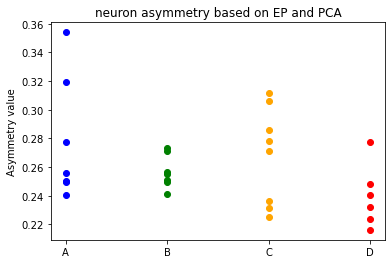

In [20]:
fig = plt.figure(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.convexity
for i,neu in enumerate(y_vals):
    plt.scatter(x_p[results_df.subtype[i]],neu,c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
x = np.array([1,2,3,4])
my_xticks = ['A','B','C','D']
plt.xticks(x, my_xticks)
plt.ylabel('Asymmetry value')
# plt.legend()
# plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)

In [21]:
reg_prop_2D.bbox

(93, 146, 411, 327)

In [44]:
type(results_df.loc[2,'PCA_xy'][0])

numpy.float64

In [28]:
PCA_df[PCA_df.Fraction_weight==PCA_df.Fraction_weight.max()]

,axis,Fraction_weight,Pixel_scale,Angle,xy
3,y_negative,0.35691,-203.438925,-352.819916,"(72.03990649174368, -9.07531672290254)"


In [31]:
PCA_df.loc[PCA_df.Fraction_weight.idxmax()].Angle

-352.8199162469222

In [24]:
img_2D.sum(), shifted_coor.shape

(20403, (20403, 2))

In [64]:
centroid_s = (sum(shifted_coor[:,0]) / len(shifted_coor), sum(shifted_coor[:,1]) / len(shifted_coor))
centroid_s

(-19.429675372194424, -56.81144706044966)

In [19]:
test = np.zeros_like(img_2D)
for px in shifted_coor:
    y,x = int(px[0])+entry_point[1], int(px[1])+entry_point[2]
    test[y,x] = 1
reg_prop = regionprops(test)[0]
test_cent = reg_prop.centroid

In [23]:
test_cent[1]-entry_point[2]

-56.890589597704036

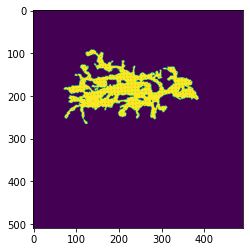

In [21]:
plt.imshow(test)

In [18]:
entry_point

[3, 204, 275]

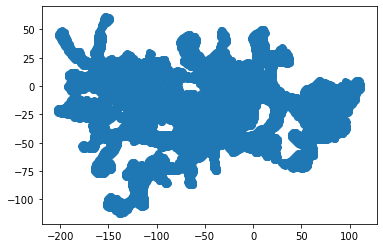

In [17]:
plt.scatter(shifted_coor[:,1],shifted_coor[:,0])

In [7]:
results_df.to_csv(save_path+'adult_T4_results.csv')

In [8]:
results_df.head()

,neuron,subtype,volume,area,area_scipy,peri_scipy,circ_scipy,dens_scipy,density,perimeter,...,xN_angle,xN_xy,yP_weight,yP_scale,yP_angle,yP_xy,yN_weight,yN_scale,yN_angle,yN_xy
0,T4-02,A,108849,27964,27651.5,663.808598,0.788575,3.936459,0.535689,704.156421,...,-260.312321,"(-0.8820511411082395, -5.166901691419008)",0.003908,112.013844,-170.312321,"(-0.4314590483098199, 0.07365515518423468)",0.003970,-146.971715,-350.312321,"(0.5751005825410065, -0.0981764615194362)"
1,T4-03,D,108692,38753,38378.0,801.486500,0.750758,2.832143,0.439450,843.553391,...,-93.252698,"(-0.37928414235887997, 6.673852998139413)",0.115012,91.193838,-3.252698,"(10.471458819771142, 0.5951072459657826)",0.526327,-246.534458,-183.252698,"(-129.5487374907479, -7.362430938552654)"
2,T4-04,B,186473,43348,42944.0,852.623692,0.742331,4.342236,0.488604,899.168614,...,-268.044659,"(-3.5579178484868996, -104.21433415715062)",0.074659,205.685251,-178.044659,"(-15.34741353843868, 0.5239666596552713)",0.057257,-146.007427,-358.044659,"(8.355140255428802, -0.28524773373857254)"
3,T4-05,D,170394,51284,50872.0,908.035625,0.775323,3.349465,0.431460,952.933116,...,-98.690900,"(-1.193525030504534, 7.808014514206264)",0.111959,95.363716,-8.690900,"(10.55422928104682, 1.613308582059391)",0.549541,-282.230528,-188.690900,"(-153.3162850032442, -23.435768901607968)"
4,T4-06,D,168232,43249,42825.0,884.861675,0.687316,3.928360,0.483086,922.742207,...,-99.428881,"(-0.09436679304058622, 0.5682458032813655)",0.121086,106.038768,-9.428881,"(12.66635343034258, 2.10346147008536)",0.467388,-259.251018,-189.428881,"(-119.53388623792972, -19.850616474093712)"


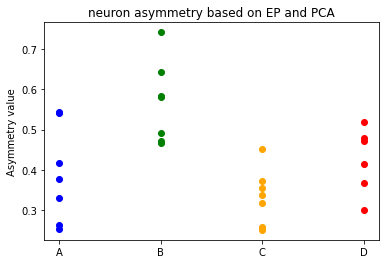

In [23]:
fig = plt.figure(1)
colors = {'A':'b','B':'g','C':'orange','D':'r'}
x_p = {'A':1,'B':2,'C':3,'D':4}
# y_vals = (results_df.surface_area/results_df.volume)
# y_vals = y_vals/y_vals.max()
y_vals = results_df.asymmetry
for i,neu in enumerate(y_vals):
    plt.scatter(x_p[results_df.subtype[i]],neu,c=colors[results_df.subtype[i]])
plt.title('neuron asymmetry based on EP and PCA')
x = np.array([1,2,3,4])
my_xticks = ['A','B','C','D']
plt.xticks(x, my_xticks)
plt.ylabel('Asymmetry value')
# plt.legend()
plt.savefig(save_path+'adult_T4_Asymmetry.png', facecolor='white', transparent=False)

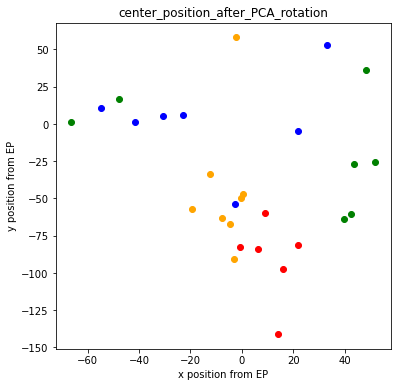

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colors = {'A':'b','B':'g','C':'orange','D':'r'}
vals = results_df.PCA_shift_centroid
for i,neu in enumerate(vals):
    ax.scatter((neu[1]),(neu[0]),c=colors[results_df.subtype[i]])
ax.set_title('center_position_after_PCA_rotation')
ax.set_xlabel('x position from EP')
ax.set_ylabel('y position from EP')
# plt.legend()
# x = np.array([1,2,3,4])
# my_xticks = ['A','B','C','D']
# plt.xticks(x, my_xticks)
# plt.ylabel('normalized ratio of surface_area to volume')
plt.savefig(save_path+'center_position_after_PCA_rotation.png', facecolor='white', transparent=False, dpi=500)

<AxesSubplot:>

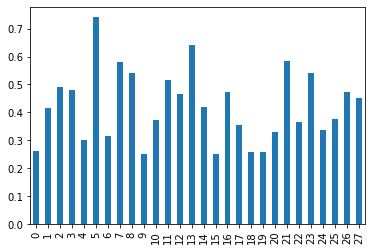

In [11]:
results_df.asymmetry.plot(kind='bar')
# results_df.circ_scipy.plot(kind='bar')